In [1]:
import pandas
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import pipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

import graphviz
import os


os.environ['PATH'] = os.environ['PATH'] + ';C:/Program Files (x86)/Graphviz2.38/bin'


plt.style.use('bmh')

datapath = '../../Data/Processed/movies.parquet'

# Carga dos Dados 

In [2]:
df = pandas.read_parquet(datapath)

print('shape:', df.shape)
print('columns:', df.columns)

shape: (2000, 2)
columns: Index(['class', 'text'], dtype='object')


# Treino / Teste 

In [3]:
X = df['text'].values.reshape(-1).tolist()
Y = (df['class'].values.reshape(-1) == 'Pos').tolist()

# Dividir 20% dos dados para o conjunto out-of-sample de teste
Xtrain, Xtest, Ytrain, Ytest = model_selection.train_test_split(X,
                                                                Y,
                                                                test_size=0.2,
                                                                random_state=0,
                                                                stratify=Y)

# Objeto de validacao cruzada
cvfold = model_selection.StratifiedKFold(n_splits = 5, random_state = 0)

# Construção do Pipeline 

In [6]:
# Configure Pipeline
model_dict = {
    'RandomForest': ensemble.RandomForestClassifier(n_estimators=10, max_features='sqrt'),
    'LogisticRegr': LogisticRegression(),
    'kNN': KNeighborsClassifier(weights='distance'),
    'SVM': SVC(probability=False, gamma='auto'),
}

model_conf = {
    'RandomForest': {
        'Model__max_depth': [4, 6],
        'Model__n_estimators': [10, 50],
    },
    'LogisticRegr': {
        'Model__C': [0.001, 0.1, 1, 10],
    },
    'kNN': {
        'Model__n_neighbors': [5, 10, 20],
    },
    'SVM': {
        'Model__kernel': ['rbf',],
        'Model__C' : [0.1, 1, 10],
    }
}

scorer = metrics.make_scorer(metrics.f1_score)

model_list = {}


for model_name in model_dict.keys():
    conf_train_pipe = [
        ('TfIDf', TfidfVectorizer(Xtrain,stop_words='english')),
        ('Model', model_dict[model_name]),
    ]
    
    # Create Pipeline
    model_pipe = pipeline.Pipeline(conf_train_pipe)
    param_grid = model_conf[model_name].copy()
    model_pipe = model_selection.GridSearchCV(model_pipe, param_grid,
                                              scoring=scorer,
                                              fit_params=None,
                                              cv=cvfold,
                                              return_train_score=True,)

    model_pipe.fit(Xtrain, Ytrain)
    model_list[model_name] = model_pipe 
         

C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Curva ROC 

Text(0, 0.5, 'Taxa de Detecção')

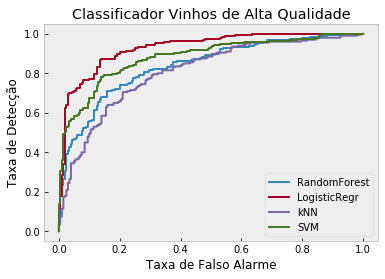

In [46]:
plt.figure(figsize=(6,4))

for model_name in model_dict.keys():
    model = model_list[model_name]
    # estimate Y
    if model_name in ['RandomForest', 'SVM']:
        final_model = LogisticRegressionCV(Cs=20,cv=5)
        if model_name == 'SVM':
            Yhat_train = model.decision_function(Xtrain)
            Yhat = model.decision_function(Xtest)
        else:
            Yhat_train = model.predict_proba(Xtrain)[:,1]
            Yhat = model.predict_proba(Xtest)[:,1]
            
        final_model.fit(Yhat_train.reshape(-1, 1), Ytrain)
        Yhat  = final_model.predict_proba(Yhat.reshape(-1,1))[:,1]
        Ypred = final_model.predict(Yhat.reshape(-1,1))
    else:
        Yhat = model.predict_proba(Xtest)[:,1]
        Ypred = model.predict(Xtest)
    
    
    fpr, tpr, thr = metrics.roc_curve(Ytest, Yhat)
    auc = metrics.roc_auc_score(Ytest, Yhat)
    f1 = metrics.f1_score(Ytest, Ypred)
    label = model_name # + " AUC: %.3f - F1: %.3f"%(auc, f1)
    plt.plot(fpr, tpr, '-', lw=2, label=label)

    
plt.legend()
plt.title('Classificador Vinhos de Alta Qualidade')
plt.grid()
plt.xlabel('Taxa de Falso Alarme')
plt.ylabel('Taxa de Detecção')

# Distribuição de Probabilidades do Modelo 

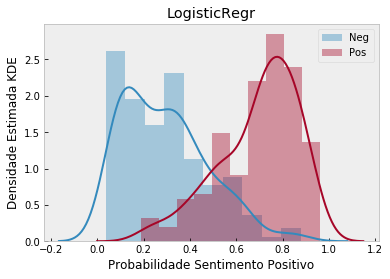

In [13]:
model_name = 'LogisticRegr'
model = model_list[model_name]
Yhat = model.predict_proba(Xtest)[:,1]

for i in [False, True]:
    # 2 Classes case
    sns.distplot(Yhat[np.array(Ytest) == i], label=['Neg','Pos'][i])

plt.title(model_name)
plt.ylabel('Densidade Estimada KDE')
plt.xlabel('Probabilidade Sentimento Positivo')
plt.grid()
plt.legend()

# Matriz de Confusão 

In [14]:
model_name = 'LogisticRegr'


model = model_list[model_name]
Ypred = model.predict(Xtest)

col_names = ['Model ' + s for s in ['Neg','Pos']]
idx_names = ['Real ' + s for s in ['Neg','Pos']]

cmat = metrics.confusion_matrix(Ytest, Ypred)
cmat = pandas.DataFrame(cmat, index=idx_names,
                              columns=col_names)
cmat['Real Total'] = cmat.sum(axis=1)
cmat.loc['Model Total',:] = cmat.sum(axis=0)
cmat = cmat.astype(int)
cmat


,Model Neg,Model Pos,Real Total
Real Neg,172,28,200
Real Pos,27,173,200
Model Total,199,201,400


In [15]:
print(metrics.classification_report(Ytest, Ypred))

              precision    recall  f1-score   support

       False       0.86      0.86      0.86       200
        True       0.86      0.86      0.86       200

   micro avg       0.86      0.86      0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



# Coeficientes de Regressão 

Text(0.5, 0, 'Coeficiente')

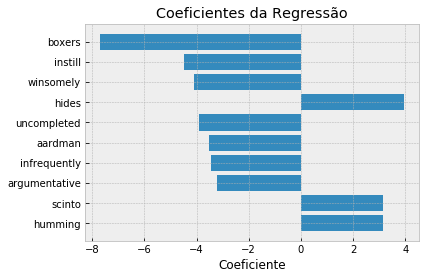

In [32]:
plt.figure(figsize=(6,4))

nshow = 10
model_name = 'LogisticRegr'
model = model_list[model_name].best_estimator_.steps[1][1]
vocabulary = model_list[model_name].best_estimator_.steps[0][1].vocabulary_
vocabulary = np.array(list(vocabulary.keys()))

coefs = model.coef_[0]

idx = np.argsort(np.abs(coefs))[-nshow:]

yaxis = np.arange(nshow)


plt.barh(yaxis, coefs[idx])
plt.yticks(yaxis, vocabulary[idx])

plt.title('Coeficientes da Regressão')
plt.xlabel('Coeficiente')


# Explicação pela Árvore de Decisão 

Text(0.5, 0, 'Importância Relativa')

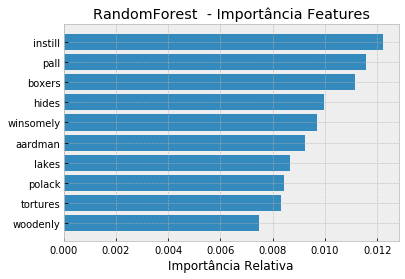

In [35]:
plt.figure(figsize=(6,4))

nshow = 10
model_name = 'RandomForest'
model = model_list[model_name].best_estimator_.steps[1][1]
vocabulary = model_list[model_name].best_estimator_.steps[0][1].vocabulary_
vocabulary = np.array(list(vocabulary.keys()))

coefs = model.feature_importances_

idx = np.argsort(np.abs(coefs))[-nshow:]

yaxis = np.arange(nshow)


plt.barh(yaxis, coefs[idx])
plt.yticks(yaxis, vocabulary[idx])

plt.title(model_name + '  - Importância Features')

plt.xlabel('Importância Relativa')

# Exportação do Resultado 

In [45]:
model_name = 'LogisticRegr'

test_data = [Xtest, Ytest,]
df_cols = ['text', 'class'] 
for model_name in model_dict.keys():
    model = model_list[model_name]
    if model_name in ['RandomForest', 'SVM']:
        final_model = LogisticRegressionCV(Cs=20,cv=5)
        if model_name == 'SVM':
            Yhat_train = model.decision_function(Xtrain)
            Yhat = model.decision_function(Xtest)
        else:
            Yhat_train = model.predict_proba(Xtrain)[:,1]
            Yhat = model.predict_proba(Xtest)[:,1]
            
        final_model.fit(Yhat_train.reshape(-1, 1), Ytrain)
        Yhat  = final_model.predict_proba(Yhat.reshape(-1,1))[:,1]
    else:
        Yhat = model.predict_proba(Xtest)[:,1]

    test_data.append(Yhat)
    df_cols.append(model_name)
        
test_data = np.array(test_data).T
df_test = pandas.DataFrame(data=test_data, columns=df_cols)

df_test.to_excel('../../Data/Modeling/results.xlsx')

df_test.head()

,text,class,RandomForest,LogisticRegr,kNN,SVM
0,a month ago i wrote that speed 2 was the wors...,False,0.3282888630247562,0.15050544773031435,0.09576116651398853,0.49999999153096825
1,love to kill starts off aimlessly and ge...,False,0.03254840759218473,0.24982605592163887,0.19972975862159534,0.499999993839839
2,close your eyes for a moment if you will ...,True,0.8062898643878434,0.6205098681640948,0.5909643404622071,0.5000000058874042
3,what were they thinking nostalgia for the ...,False,0.6124085715935593,0.4336357833725045,0.39858418122854494,0.4999999983988359
4,you ve got to think twice before you go see a...,True,0.8768435100796399,0.33225242886963063,0.11838444062744313,0.4999999906533971
